- [1. Import Packages and Functions](#1)
- [2. Assembling Dataset](#2)
- [3. Model Training](#3)
  - [3.1 LSTM from Scratch](#3_1)
      - [3.1.1 Univariate](#3_1_1)
      - [3.1.2 Multivariate](#3_1_2)
  - [3.2 Baseline Model from Article](#3_2)
      - [3.2.1 Univariate](#3_1_1)
      - [3.2.2 Multivariate](#3_1_2)

## 1. Import Packages and Functions <a id='1'></a>

In [73]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler



In [220]:
def create_sequences(target, timesteps):
    X, y = [], []
    for i in range(len(target) - timesteps):
        X.append(target[i:(i + timesteps)])
        y.append(target[i + timesteps])
    return np.array(X), np.array(y)


def create_sequences_with_exogenous(features, target, timesteps):
    X, y = [], []
    for i in range(len(features) - timesteps + 1):
        # Extracting the exogenous features for the past 'timesteps' and including the current timestep
        X.append(features[i:(i + timesteps)])  # '+1' to include current timestep features
        # The target is the value at the current timestep
        y.append(target[i + timesteps - 1])
    return np.array(X), np.array(y)


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def mae(predictions, targets):
    return np.abs(predictions - targets).mean()


def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions) / targets)) * 100


def theil_u_statistic(predictions, targets):
    numerator = np.sqrt(((predictions - targets) ** 2).mean())
    denominator = np.sqrt((predictions ** 2).mean()) + np.sqrt((targets ** 2).mean())
    return numerator / denominator



## 2. Assembling Dataset <a id='2'></a>

In [76]:
all_features_path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_engineered_selected_features.csv'
all_features = pd.read_csv(all_features_path)
all_features.columns

Index(['date', 'close', 'Volume BTC', 'Volume USD', '5_day_vol',
       'rsi_14_over_30', 'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol',
       'target'],
      dtype='object')

In [221]:
timesteps = 10
np.random.seed(0)

features = all_features[['close', 'Volume BTC', 'Volume USD', '5_day_vol',
       'rsi_14_over_30', 'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol']]
target = all_features['target'].to_numpy().reshape(-1, 1)

X_uni, y_uni = create_sequences(target, timesteps)
X_train_uni, X_test_uni, y_train_uni, y_test_uni = train_test_split(X_uni, y_uni, test_size=0.2, shuffle=False, random_state=0)

scaler = StandardScaler()

target = all_features['target'].to_numpy()
features_scaled = scaler.fit_transform(features)

X_multi, y_multi = create_sequences_with_exogenous(features_scaled, target, timesteps)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, shuffle=False, random_state=0)


## 3. Model Training <a id='3'></a>

### 3.1 LSTM from Scratch <a id='3_1'></a>

#### 3.1.1 Univariate <a id='3_1_1'></a>

In [169]:
lstm_simple_univariate = Sequential([
    LSTM(50, input_shape=(X_train_uni.shape[1], 1)),  
    Dense(1)
])

lstm_simple_univariate.compile(optimizer='adam', loss='mse')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [170]:
history = lstm_simple_univariate.fit(X_train_uni, y_train_uni, epochs=20, batch_size=32, validation_data=(X_test_uni, y_test_uni))
test_loss = lstm_simple_univariate.evaluate(X_test_uni, y_test_uni)
print(f"Test Loss: {test_loss}")
predictions_simple_univariate = lstm_simple_univariate.predict(X_test_uni)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.8039e-04 - val_loss: 1.1115e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1006e-04 - val_loss: 9.2659e-05
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4947e-04 - val_loss: 9.0451e-05
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3409e-04 - val_loss: 7.1439e-05
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1214e-04 - val_loss: 6.8193e-05
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1918e-04 - val_loss: 5.9421e-05
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6702e-05 - val_loss: 6.1494e-05
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2995e-05 - val_loss: 5.1171e-05
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9786e-05 - val_loss: 4.8561e-05
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3869e-05 - val_loss: 4.6471e-05
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6816e-05 - val_los

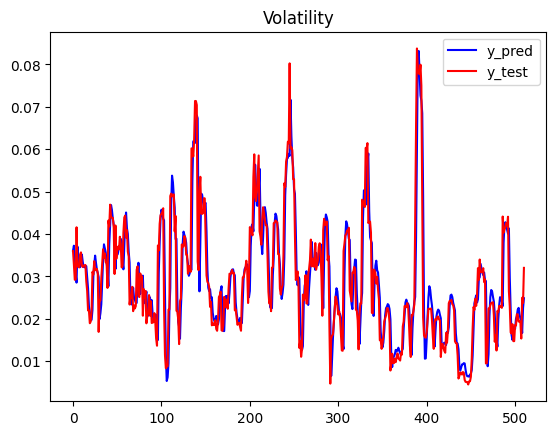

In [172]:
y_pred_simple_uni = pd.Series([i[0] for i in predictions_simple_univariate])
y_test_simple_uni = pd.Series([i[0] for i in y_test_uni])
_ = y_pred_simple_uni.plot(color='blue', label='y_pred')
_ = y_test_simple_uni.plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

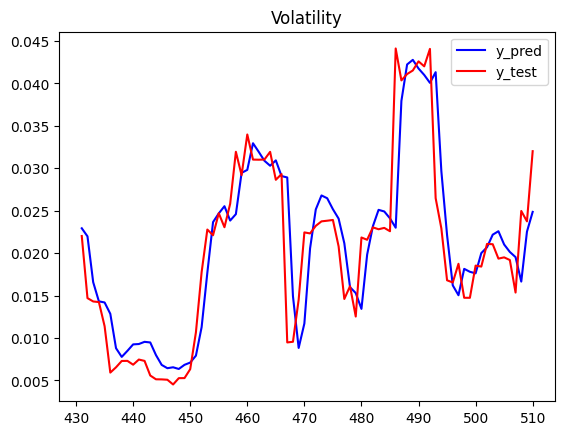

In [173]:
_ = y_pred_simple_uni.iloc[-80:].plot(color='blue', label='y_pred')
_ = y_test_simple_uni.iloc[-80:].plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

In [202]:
predictions_simple_uni_eval = predictions_simple_univariate.flatten()
y_test_uni_eval = y_test_uni.flatten()

In [203]:
print("RMSE:", rmse(predictions_simple_uni_eval, y_test_uni_eval))
print("MAE:", mae(predictions_simple_uni_eval, y_test_uni_eval))
print("MAPE:", mape(predictions_simple_uni_eval, y_test_uni_eval))
print("Theil U Statistic:", theil_u_statistic(predictions_simple_uni_eval, y_test_uni_eval))

RMSE: 0.0065251688578005845
MAE: 0.0042320361264809635
MAPE: 17.594636248660116
Theil U Statistic: 0.1008939726362163


#### 3.1.2 Multivariate <a id='3_1_2'></a>

In [222]:
lstm_univariate_with_exogenous = Sequential([
    LSTM(50, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2])),  # Input shape is (10, 8)
    Dense(units=1)
])

lstm_univariate_with_exogenous.compile(optimizer='adam', loss='mse')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [223]:
history = lstm_univariate_with_exogenous.fit(X_train_multi, y_train_multi, epochs=20, batch_size=32, validation_data=(X_test_multi, y_test_multi))
test_loss = lstm_univariate_with_exogenous.evaluate(X_test_multi, y_test_multi)
print(f"Test Loss: {test_loss}")
predictions_simple_multi = lstm_univariate_with_exogenous.predict(X_test_multi)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0126 - val_loss: 9.6766e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6262e-04 - val_loss: 5.8671e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7427e-04 - val_loss: 5.1801e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8011e-04 - val_loss: 4.1194e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1069e-04 - val_loss: 3.6407e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7349e-04 - val_loss: 3.1566e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5473e-04 - val_loss: 3.5601e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3972e-04 - val_loss: 2.5232e-04
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1738e-04 - val_loss: 2.2769e-04
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1718e-04 - val_loss: 2.0257e-04
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2360e-04 - val_loss: 2

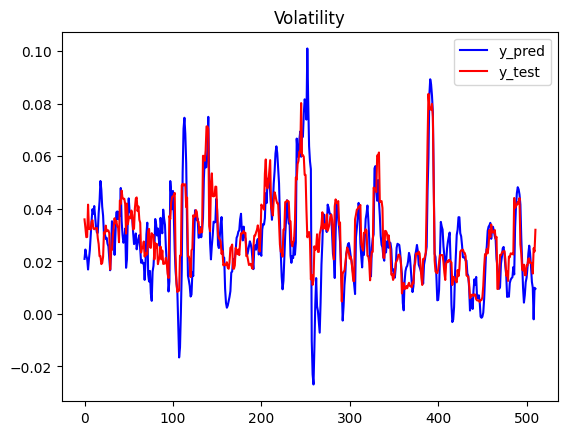

In [224]:
y_pred_simple_multi = pd.Series([i[0] for i in predictions_simple_multi])
y_test_simple_multi = pd.Series(y_test_multi)
_ = y_pred_simple_multi.plot(color='blue', label='y_pred')
_ = y_test_simple_multi.plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

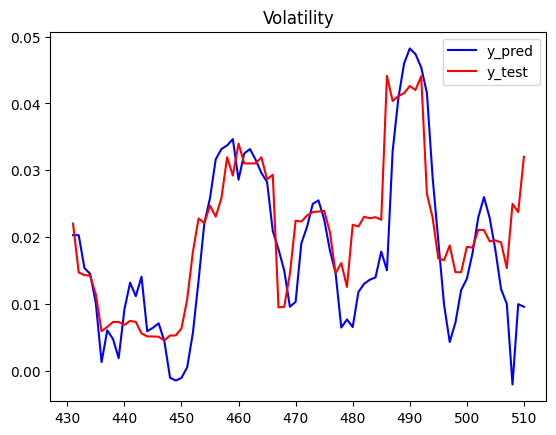

In [225]:
_ = y_pred_simple_multi.iloc[-80:].plot(color='blue', label='y_pred')
_ = y_test_simple_multi.iloc[-80:].plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

In [226]:
predictions_simple_multi_eval = predictions_simple_multi.flatten()
y_test_multi_eval = y_test_multi.flatten()

In [227]:

print("RMSE:", rmse(predictions_simple_multi_eval, y_test_multi_eval))
print("MAE:", mae(predictions_simple_multi_eval, y_test_multi_eval))
print("MAPE:", mape(predictions_simple_multi_eval, y_test_multi_eval))
print("Theil U Statistic:", theil_u_statistic(predictions_simple_multi_eval, y_test_multi_eval))

RMSE: 0.012090640336431296
MAE: 0.008648061733929945
MAPE: 35.58089119370672
Theil U Statistic: 0.1863331892543613


#### Notes:
- Although the multi model has more numerical errors, it actually is better in terms of hit rate
- It could actually predict future volatility move better than univariate model

### 3.2 Baseline Model from Article <a id='3_2'></a>

### 3.2.1 Univariate <a id='3_2_1'></a>

In [208]:
lstm_base_univariate = Sequential([
    LSTM(50, input_shape=(X_train_uni.shape[1], X_train_uni.shape[2]), return_sequences=True),  # Input shape is (10, 8)
    Dropout(rate=0.2),
    Dense(units=10, activation='relu'),
    GRU(units=50, return_sequences=False),  # Since it's followed by a Dense layer, return_sequences is False
    Dropout(rate=0.2),
    Dense(units=1)
])

lstm_base_univariate.compile(optimizer='adam', loss='mse')


history = lstm_base_univariate.fit(X_train_uni, y_train_uni, epochs=20, batch_size=32, validation_data=(X_test_uni, y_test_uni))
test_loss = lstm_base_univariate.evaluate(X_test_uni, y_test_uni)
print(f"Test Loss: {test_loss}")
predictions_base_uni = lstm_base_univariate.predict(X_test_uni)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6127e-04 - val_loss: 2.6530e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1656e-04 - val_loss: 1.2958e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2130e-04 - val_loss: 1.5139e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7809e-04 - val_loss: 7.8056e-05
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3937e-04 - val_loss: 6.4682e-05
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1042e-04 - val_loss: 5.6047e-05
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1253e-04 - val_loss: 5.2013e-05
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0084e-04 - val_loss: 5.0455e-05
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3917e-05 - val_loss: 4.7009e-05
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0311e-05 - val_loss: 4.5223e-05
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0237e-04 - val_lo

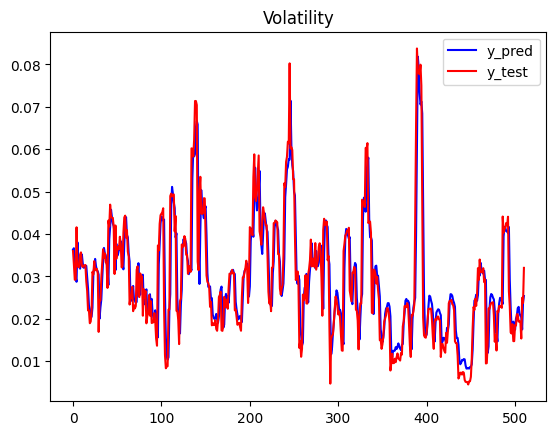

In [209]:
y_pred_bench_uni = pd.Series([i[0] for i in predictions_base_uni])
y_test_bench_uni = pd.Series(y_test_uni.flatten())
_ = y_pred_bench_uni.plot(color='blue', label='y_pred')
_ = y_test_bench_uni.plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

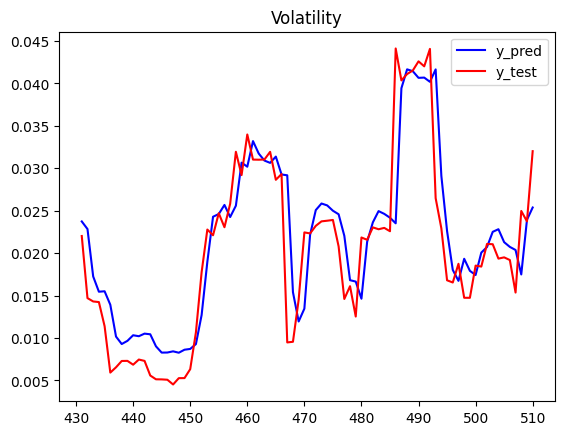

In [210]:
_ = y_pred_bench_uni.iloc[-80:].plot(color='blue', label='y_pred')
_ = y_test_bench_uni.iloc[-80:].plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()


In [211]:
predictions_base_uni_eval = predictions_base_uni.flatten()

print("RMSE:", rmse(predictions_base_uni_eval, y_test_uni_eval))
print("MAE:", mae(predictions_base_uni_eval, y_test_uni_eval))
print("MAPE:", mape(predictions_base_uni_eval, y_test_uni_eval))
print("Theil U Statistic:", theil_u_statistic(predictions_base_uni_eval, y_test_uni_eval))

RMSE: 0.0064231481857804276
MAE: 0.004134014961499112
MAPE: 18.075258980708487
Theil U Statistic: 0.09957932032811466


### 3.2.2 Multivariate <a id='3_2_2'></a>

In [228]:
lstm_bench_multi = Sequential([
    LSTM(50, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2]), return_sequences=True),  # Input shape is (10, 8)
    Dropout(rate=0.2),
    Dense(units=10, activation='relu'),
    GRU(units=50, return_sequences=False),  # Since it's followed by a Dense layer, return_sequences is False
    Dropout(rate=0.2),
    Dense(units=1)
])

lstm_bench_multi.compile(optimizer='adam', loss='mse')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [229]:
history = lstm_bench_multi.fit(X_train_multi, y_train_multi, epochs=20, batch_size=32, validation_data=(X_test_multi, y_test_multi))
test_loss = lstm_bench_multi.evaluate(X_test_multi, y_test_multi)
print(f"Test Loss: {test_loss}")
predictions_bench_multi = lstm_bench_multi.predict(X_test_multi)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0023 - val_loss: 1.3790e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8575e-04 - val_loss: 1.8228e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5515e-04 - val_loss: 1.3274e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4313e-04 - val_loss: 1.0747e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0484e-04 - val_loss: 9.9228e-05
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8505e-04 - val_loss: 1.5472e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8674e-04 - val_loss: 8.9061e-05
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8376e-04 - val_loss: 1.0572e-04
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5122e-04 - val_loss: 8.1516e-05
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7540e-04 - val_loss: 7.6866e-05
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5876e-04 - val_loss: 

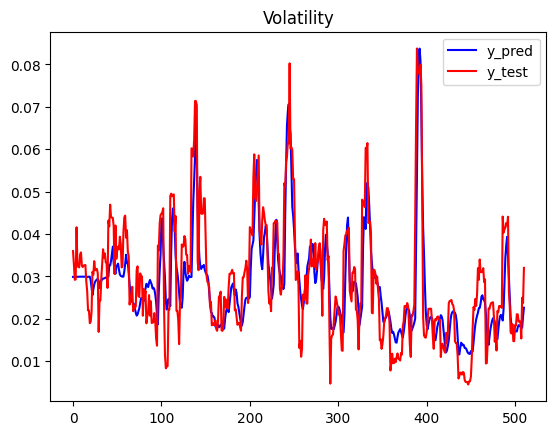

In [230]:
y_pred_bench_multi = pd.Series([i[0] for i in predictions_bench_multi])
y_test_multi = pd.Series(y_test_multi)
_ = y_pred_bench_multi.plot(color='blue', label='y_pred')
_ = y_test_multi.plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

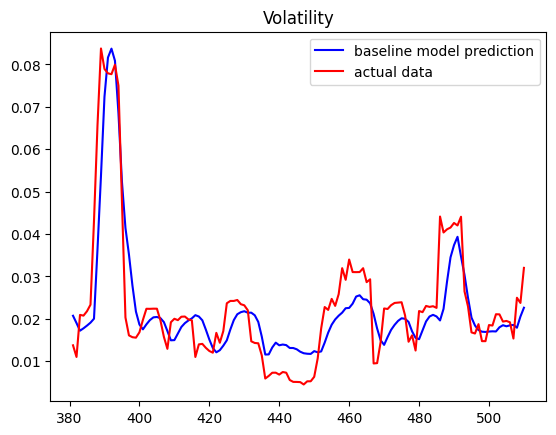

In [231]:
_ = y_pred_bench_multi.iloc[-130:].plot(color='blue', label='baseline model prediction')
_ = y_test_multi.iloc[-130:].plot(color='red', label='actual data')

_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

In [233]:
predictions_bench_multi_eval = predictions_bench_multi.flatten()

print("RMSE:", rmse(predictions_bench_multi_eval, y_test_multi_eval))
print("MAE:", mae(predictions_bench_multi_eval, y_test_multi_eval))
print("MAPE:", mape(predictions_bench_multi_eval, y_test_multi_eval))
print("Theil U Statistic:", theil_u_statistic(predictions_bench_multi_eval, y_test_multi_eval))

RMSE: 0.00762059261626673
MAE: 0.005794142851618999
MAPE: 25.737239435648274
Theil U Statistic: 0.12223676990644011
